### Neural Machine Translation using word level language model and embeddings in Keras

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
# Building a english to french translator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Machine Translation Keras/fra.txt'

In [4]:
lines= pd.read_table(path, names=['eng', 'fr', 'exclude'])
lines.drop('exclude', axis = 1, inplace = True)

In [5]:
lines.head()

,eng,fr
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [6]:
lines.shape

(174481, 2)

In [7]:
lines = lines[: 30000]
lines.shape

(30000, 2)

In [8]:
lines['eng'] = lines['eng'].apply(lambda x: x.lower())
lines['fr'] = lines['fr'].apply(lambda x: x.lower())

In [9]:
# Take the length as 50
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

In [10]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [11]:
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))

In [12]:
lines.head()

,eng,fr
0,go,va
1,hi,salut
2,hi,salut
3,run,cours
4,run,courez


#### Generate synthetic data

In [13]:
lines['fr'] = lines['fr'].apply(lambda x: '<sos> ' + x + ' <eos>')

In [14]:
all_source_words = set()
for sent in lines['eng']:
    for word in sent.split():
        if word not in all_source_words:
            all_source_words.add(word)
print(f'Total unique words in source: {len(all_source_words)}')
source_words = sorted(all_source_words)

all_target_words = set()
for sent in lines['fr']:
    for word in sent.split():
        if word not in all_target_words:
            all_target_words.add(word)
print(f'Total unique words in target: {len(all_target_words)}')
target_words = set(all_target_words)

Total unique words in source: 4434
Total unique words in target: 9234


In [15]:
source_lenght_list=[]
for l in lines.eng:
    source_lenght_list.append(len(l.split(' ')))
print(f'Max Length of the sentence in the source: {max(source_lenght_list)}')
max_source_length = max(source_lenght_list)

target_lenght_list=[]
for l in lines.fr:
    target_lenght_list.append(len(l.split(' ')))
print(f'Max Length of the sentence in the target: {max(target_lenght_list)}')
max_target_length = max(target_lenght_list)

Max Length of the sentence in the source: 6
Max Length of the sentence in the target: 14


In [16]:
# this can be done using tokenizer also

source_word2idx = dict(
    [(word, index+1) for index, word in enumerate(source_words)]
     )

target_word2idx = dict(
    [(word, index+1) for index, word in enumerate(target_words)]
    )

In [17]:
target_word2idx['<sos>']

5972

In [18]:
# creating dict for index to word for source and target lang for inference
source_idx2word = dict([
    (idx, word) for word, idx in source_word2idx.items()
])

target_idx2word = dict([
    (idx, word) for word, idx in target_word2idx.items()
])

In [19]:
# splitting data
from sklearn.model_selection import train_test_split

X, y = lines.eng, lines.fr
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [20]:
# Input tokens for encoder
num_encoder_tokens=len(source_words)
# Input tokens for decoder zero padded
num_decoder_tokens=len(target_words) +1

In [21]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
            
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = source_word2idx[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_word2idx[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, target_word2idx[word]] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model building

In [22]:
# del model

In [23]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50
latent_dim=256

In [24]:
num_encoder_tokens, num_decoder_tokens

(4434, 9235)

In [25]:
import keras
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense

In [26]:
encode_inputs = Input(shape = (None,))
enc_embedding = Embedding(num_encoder_tokens + 1, 256)(encode_inputs)

encoder_lstm = LSTM(256, return_state = True)
encoder_out, state_h, state_c = encoder_lstm(enc_embedding) 

encoder_states = [state_h, state_c]

In [27]:
encoder_states

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>]

In [28]:
# building decoder
# decoder_inputs = Input(shape = (None, ))
# decoder_embedding = Embedding(num_decoder_tokens + 1, latent_dim, mask_zero = True)#(decoder_inputs)
# dec_emb = decoder_embedding(decoder_inputs)

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True)

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation = 'softmax')

decoder_outputs = decoder_dense(decoder_outputs)

In [29]:
model = Model([encode_inputs, decoder_inputs], decoder_outputs)

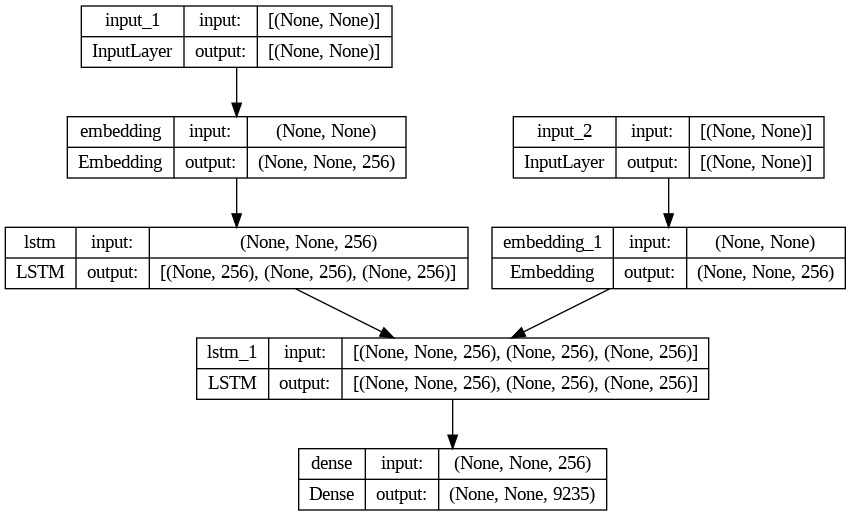

In [30]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/Machine Translation Keras/model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [31]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [32]:
train_samples = len(X_train) # Total Training samples
val_samples = len(X_test)    # Total validation or test samples
batch_size = 128
epochs = 50

In [33]:
history = model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/50
210/210 [==============================] - 188s 861ms/step - loss: 5.5973 - acc: 0.2412 - val_loss: 4.9682 - val_acc: 0.2724
Epoch 2/50
210/210 [==============================] - 180s 856ms/step - loss: 4.6095 - acc: 0.2944 - val_loss: 4.4622 - val_acc: 0.3205
Epoch 3/50
210/210 [==============================] - 187s 893ms/step - loss: 4.0711 - acc: 0.3506 - val_loss: 3.9786 - val_acc: 0.3854
Epoch 4/50
210/210 [==============================] - 188s 894ms/step - loss: 3.5539 - acc: 0.4189 - val_loss: 3.6188 - val_acc: 0.4397
Epoch 5/50
210/210 [==============================] - 188s 896ms/step - loss: 3.1752 - acc: 0.4599 - val_loss: 3.3827 - val_acc: 0.4665
Epoch 6/50
210/210 [==============================] - 195s 925ms/step - loss: 2.8797 - acc: 0.4891 - val_loss: 3.2099 - val_acc: 0.4857
Epoch 7/50
210/210 [==============================] - 190s 904ms/step - loss: 2.6250 - acc: 0.5149 - val_loss: 3.0664 - val_acc: 0.5022
Epoch 8/50
210/210 [============================

In [34]:
model.save_weights('/content/drive/MyDrive/Machine Translation Keras/nmt_weights_100epochs.h5')

In [35]:
# loading weights
model_path = '/content/drive/MyDrive/Machine Translation Keras/nmt_weights_100epochs.h5'

In [36]:
from keras.models import load_model

In [38]:
# model = load_model(model_path)

In [39]:
# encoder inputs
encoder_model = Model(encode_inputs, encoder_states)

# decoder model
# this will be placeholder for decoder states
decoder_state_input_h = Input(shape = (latent_dim, ))
decoder_state_input_c = Input(shape = (latent_dim, ))

decoder_state_input = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding2, initial_state=decoder_state_input)

decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model([decoder_inputs] + decoder_state_input, [decoder_outputs2] + decoder_states2)

In [40]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encode_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = target_word2idx['<sos>']
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
# Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True
# Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return decoded_sentence

In [42]:
# Make predictions on the training dataset
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [43]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_train[k:k+1].values[0])
print('Actual Target Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 23ms/step
Input Source sentence: lets move the bed
Actual Target Translation: bougeons le lit  <
Predicted Target Translation:  bougeons le lit <


In [44]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=10
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_test[k:k+1].values[0])
print('Actual Target Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 21ms/step
Input Source sentence: its your choice
Actual Target Translation: cest ton choix <
Predicted Target Translation:  tu passes en premier <


### we get correct predictions on some results but few are wrong.
    - The reason could be:
        - More data is needed to train the model.
        - Overfitting can be removed using mre data and hyperparameter tunung.
        - BLEU score can be used to measure the accutacy of the model.